# LIME

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

import torch
from torchvision import models

from captum.attr import Lime

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import display_imagenet_output
from utils.datasets import preprocess_imagenet_image

## Load model and sample image

In [ ]:
# Download example image
import sys
sys.path.append('../')

from utils.download import save_image

url = "https://upload.wikimedia.org/wikipedia/commons/c/ce/Canis_latrans_%28Yosemite%2C_2009%29.jpg"
save_image(url, "coyote.png")

: 

Figure saved to /Users/conorosullivan/Documents/XAI/lime_input.pdf


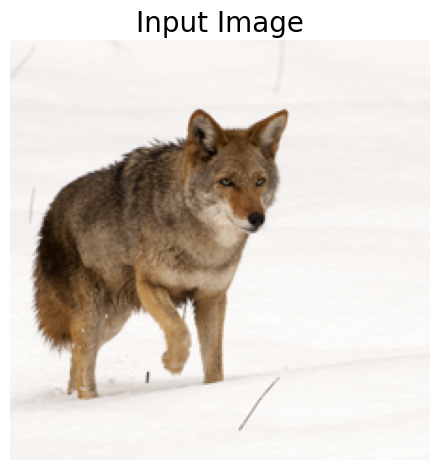

In [5]:
# Load a sample image
img_path = "coyote.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

In [6]:
# Load the pre-trained model (e.g., efficientnet_b0)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Set the model to gpu
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Preprocess the image
img_tensor = preprocess_imagenet_image(img_path)
img_tensor = img_tensor.to(device)

with torch.no_grad():
    predictions = model(img_tensor)

# Decode the output
display_imagenet_output(predictions,n=5)

coyote 0.7475791573524475
timber wolf 0.14468714594841003
red wolf 0.016246657818555832
dingo 0.006272103637456894
white wolf 0.0049531529657542706


tensor(272, device='mps:0')

## SLIC superpixel segmentation

Figure saved to /Users/conorosullivan/Documents/XAI/lime_superpixels.pdf


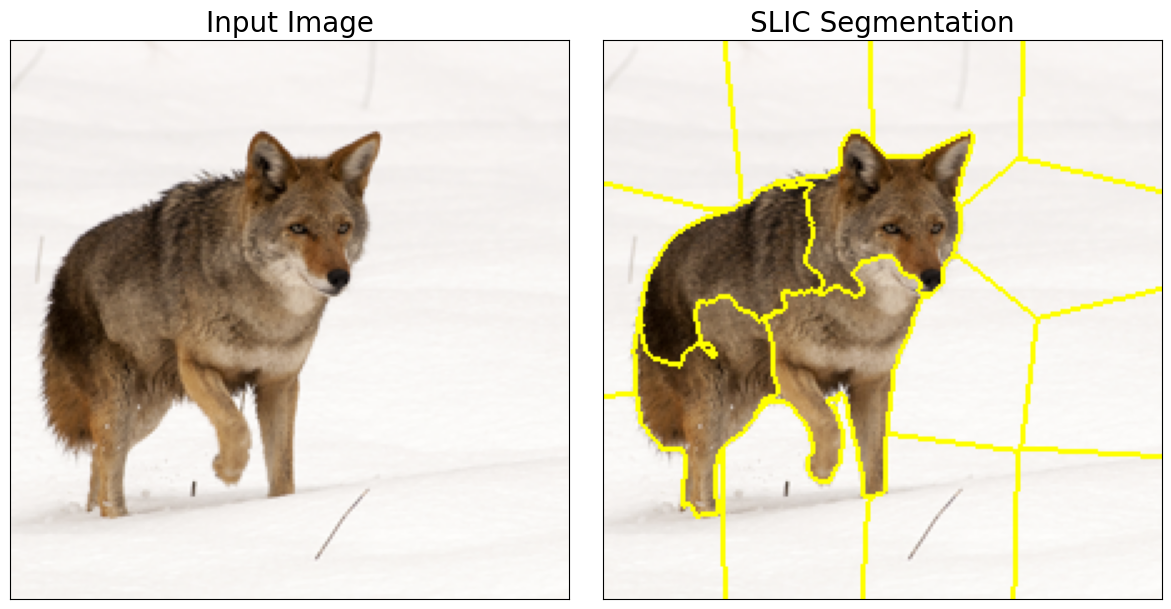

In [8]:
# Apply SLIC superpixel segmentation
img = np.array(img)
segments = slic(img, n_segments=20, compactness=30,sigma=1)

# Visualize the segmentation results
boudaries = mark_boundaries(img, segments)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Input Image")
ax[1].imshow(boudaries)
ax[1].set_title("SLIC Segmentation")

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Lime attribution

In [9]:
# Get the predicted class index
target_class = predictions.argmax().item()

print(f"Predicted class index: {target_class}")

# Format segments for LIME
feature_mask = torch.from_numpy(segments).unsqueeze(0).to(device)

Predicted class index: 272


In [10]:
# Get LIME attribution
lime = Lime(model)
attr = lime.attribute(img_tensor,
                        target=target_class,
                        feature_mask=feature_mask,
                        n_samples=500)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/lime.py:1136: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  feature_mask, num_interp_features = construct_feature_mask(


Figure saved to /Users/conorosullivan/Documents/XAI/lime_attribution.png


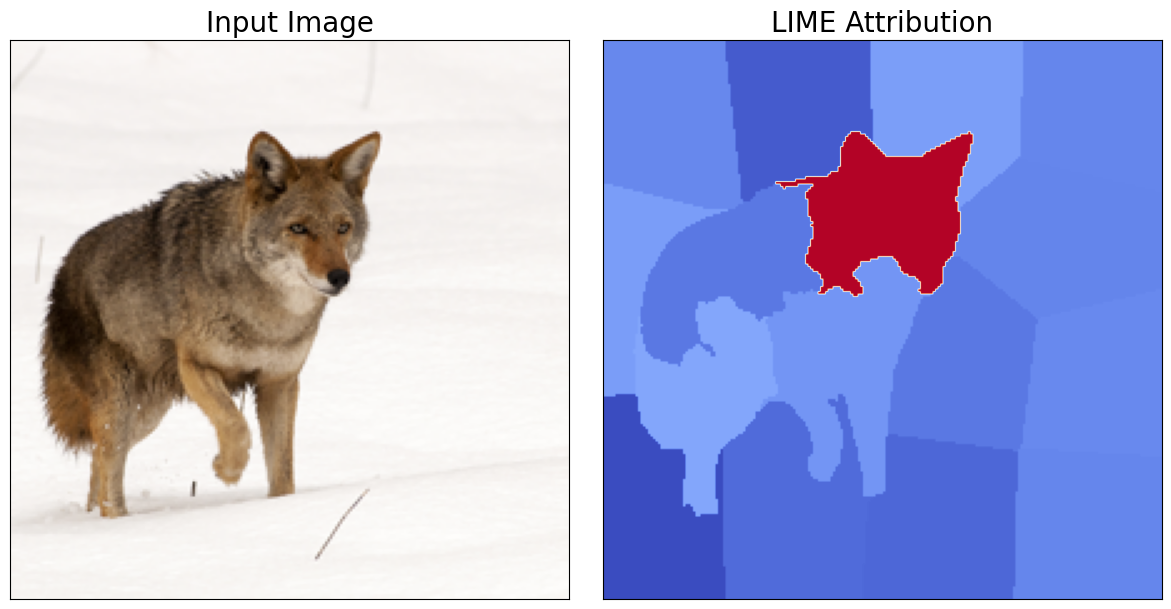

In [11]:
# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr,axis=0) # Average across channels
processed_attr = processed_attr - np.min(processed_attr) # Scale to [0,1]
processed_attr = processed_attr/np.max(processed_attr)

# Visualise attribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title("Input Image")

ax[1].imshow(processed_attr, cmap = 'coolwarm')
ax[1].set_title("LIME Attribution")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

## Different distance calculations

In [12]:
from typing import Tuple, Union, Any
import torch.nn.functional as F

def euclidean_similarity_func(
    original_input: Union[torch.Tensor, Tuple[torch.Tensor, ...]],
    perturbed_input: Union[torch.Tensor, Tuple[torch.Tensor, ...]],
    perturbed_interpretable_input: torch.Tensor,
    **kwargs: Any
) -> torch.Tensor:
    """
    Calculate similarity weights using Euclidean distance.

    Args:
        original_input: Original input tensor
        perturbed_input: Perturbed input tensor
        perturbed_interpretable_input: Binary vector of interpretable features [1 x num_features]
        kernel_width: Width parameter for exponential kernel (sigma)
        **kwargs: Additional arguments (baselines, feature_mask, etc.)

    Returns:
        Weight (similarity) for this sample
    """

    # Create original binary vector (all superpixels on)
    num_features = perturbed_interpretable_input.shape[1]
    original_binary = torch.ones(1, num_features, device=perturbed_interpretable_input.device)

    # Calculate distance (Euclidean)
    distance = torch.norm(original_binary - perturbed_interpretable_input, p=2)

    # Calculate kernel width
    kernel_width = 0.75 * np.sqrt(num_features) # LIME paper default

    # Apply exponential kernel
    weight = torch.exp(-(distance ** 2) / (kernel_width ** 2))

    return weight

In [ ]:
# Get LIME attribution
lime = Lime(model,
            similarity_func=euclidean_similarity_func)
attr = lime.attribute(
    img_tensor,
    target=target_class,
    feature_mask=feature_mask,
    n_samples=500)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/lime.py:1136: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  feature_mask, num_interp_features = construct_feature_mask(


In [14]:
attributions = {}
attributions['Cosine'] = processed_attr

# Process attribution
processed_attr = attr.detach().cpu().numpy()[0]
processed_attr = np.mean(processed_attr, axis=0)

# Normalize
processed_attr = processed_attr - np.min(processed_attr)
processed_attr = processed_attr / np.max(processed_attr)

attributions['Euclidean'] = processed_attr

Figure saved to /Users/conorosullivan/Documents/XAI/lime_distance_methods.pdf


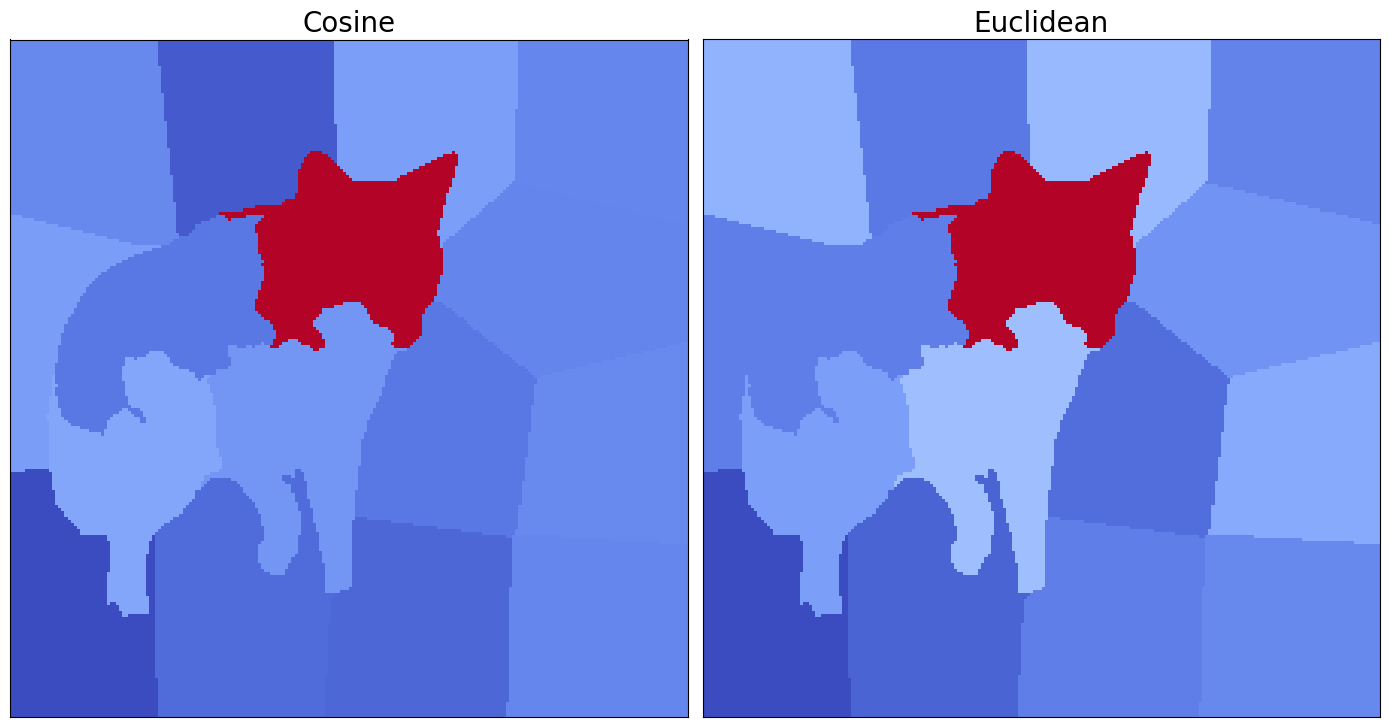

In [15]:
# Visualize all three
fig, axs = plt.subplots(1, 2, figsize=(14, 12))


for idx, mode in enumerate(['Cosine', 'Euclidean']):
    axs[idx].imshow(attributions[mode], cmap='coolwarm')
    axs[idx].set_title(f"{mode}")

# Remove ticks from all subplots
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])